<a href="https://colab.research.google.com/github/OscarSkog/Monkey_Classifier/blob/main/monkey_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [102]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [103]:
key = os.environ.get('AZURE_SEARCH_KEY', 'fc420b85294341bf8d7553841b704619')

In [104]:
search_images_bing


<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [105]:
result = search_images_bing(key, 'orangutang')
ims = result.attrgot('contentUrl')
len(ims)

147

In [106]:
print(ims[0])

https://cdn.britannica.com/69/65969-050-8E4B0AB9/Orangutan.jpg


In [107]:
dest = "images/orangutan.jpg"
download_url(ims[0], dest)

Path('images/orangutan.jpg')

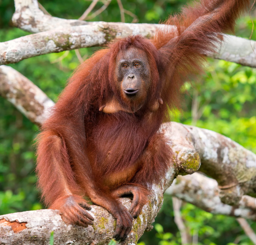

In [108]:
im = Image.open(dest)
im.to_thumb(256,256)

In [109]:
monkey_types = 'orangutan', 'gorilla', 'chimpanzee'
path = Path('monkey')

In [110]:
if not path.exists():
    path.mkdir()
    for o in monkey_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} monkey')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [111]:
fns = get_image_files(path)
fns

(#391) [Path('monkey/gorilla/bab42ca6-8379-4b23-9b35-c82ac19fd91b.jpg'),Path('monkey/gorilla/b2d74391-8c7c-41b4-8815-44fe78f4038e.jpg'),Path('monkey/gorilla/159157bc-a392-431c-a018-e8205ae21d40.jpg'),Path('monkey/gorilla/df881339-7913-40e3-97da-9344064a8ee0.jpg'),Path('monkey/gorilla/173cf0bb-9423-45b1-ba1d-b57c430af676.jpg'),Path('monkey/gorilla/a4000cd4-a78a-47b7-8dcc-e84e803c04ff.jpg'),Path('monkey/gorilla/e3922bb0-112d-46f2-b87a-e425dd78b092.jpg'),Path('monkey/gorilla/6d539131-8f58-4d84-a1fa-3a45a1fb1fbc.jpg'),Path('monkey/gorilla/72b72287-c02c-4a99-916e-c6f2fc4b66da.jpg'),Path('monkey/gorilla/85271946-2586-4483-8188-1ba3d09c9d53.jpg')...]

In [112]:
failed = verify_images(fns)
failed

(#0) []

In [113]:
failed.map(Path.unlink);

In [114]:
monkeys = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [115]:
dls = monkeys.dataloaders(path)

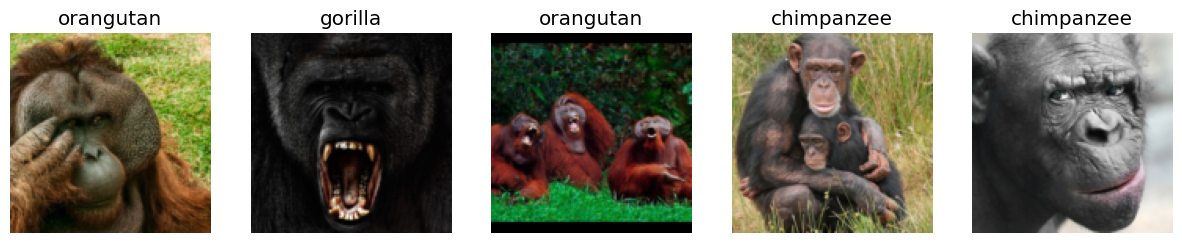

In [116]:
dls.valid.show_batch(max_n = 5, nrows=1)

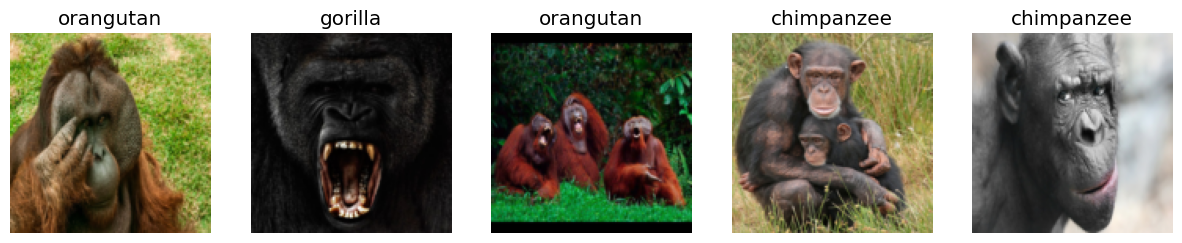

In [117]:
monkeys = monkeys.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = monkeys.dataloaders(path)
dls.valid.show_batch(max_n = 5, nrows=1)

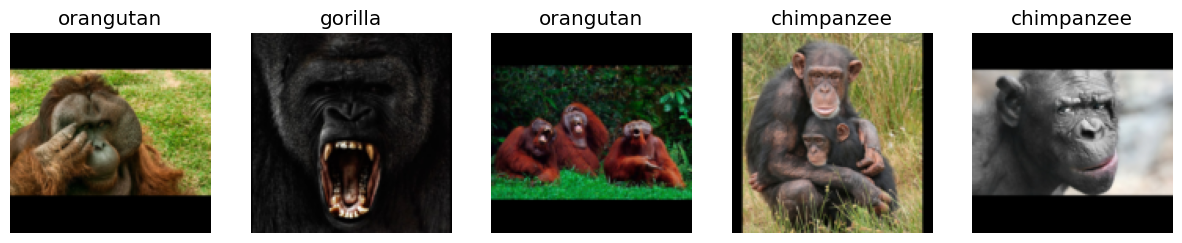

In [118]:
monkeys = monkeys.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = monkeys.dataloaders(path)
dls.valid.show_batch(max_n = 5, nrows=1)

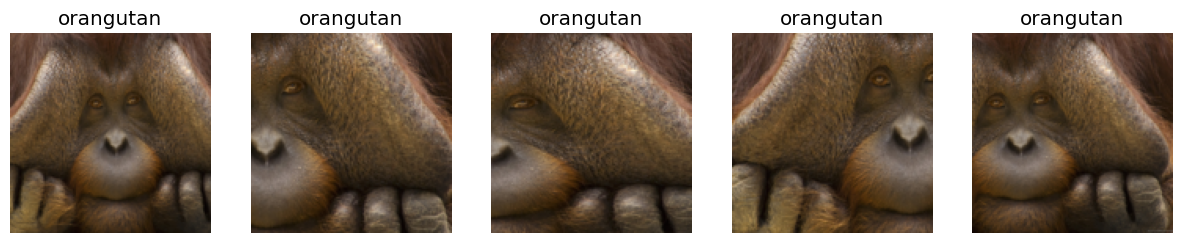

In [119]:
monkeys = monkeys.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = monkeys.dataloaders(path)
dls.train.show_batch(max_n = 5, nrows=1, unique=True)

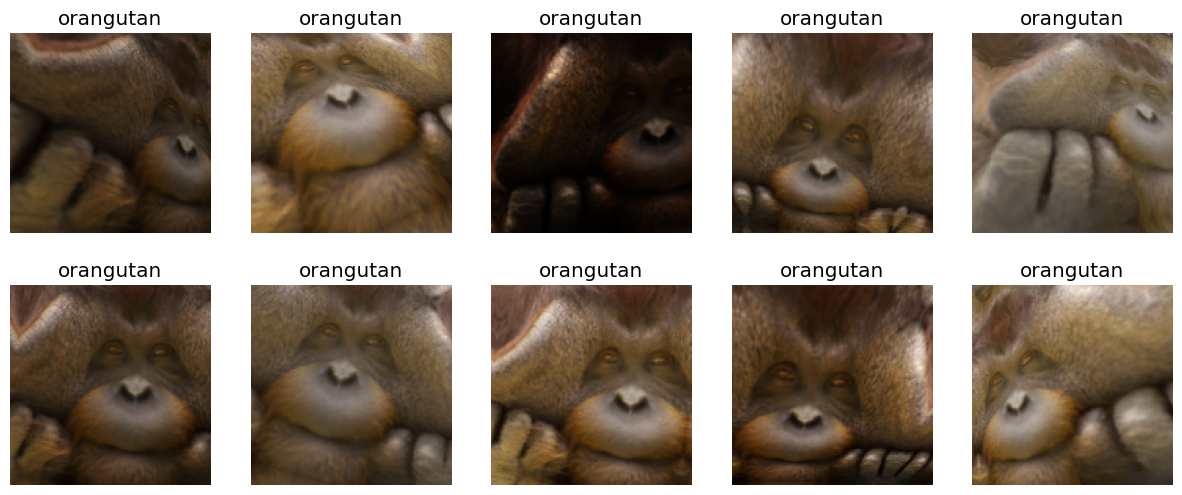

In [120]:
monkeys = monkeys.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = monkeys.dataloaders(path)
dls.train.show_batch(max_n = 10, nrows=2, unique=True)

In [121]:
monkeys = monkeys.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = monkeys.dataloaders(path)

In [122]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.510013,0.447245,0.179487,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.676814,0.276581,0.076923,00:13
1,0.560367,0.139691,0.064103,00:13
2,0.430134,0.088075,0.051282,00:13
3,0.344070,0.097012,0.051282,00:12
4,0.296598,0.103452,0.051282,00:17


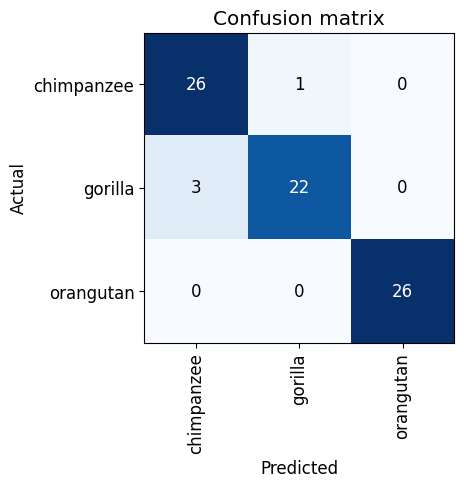

In [123]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

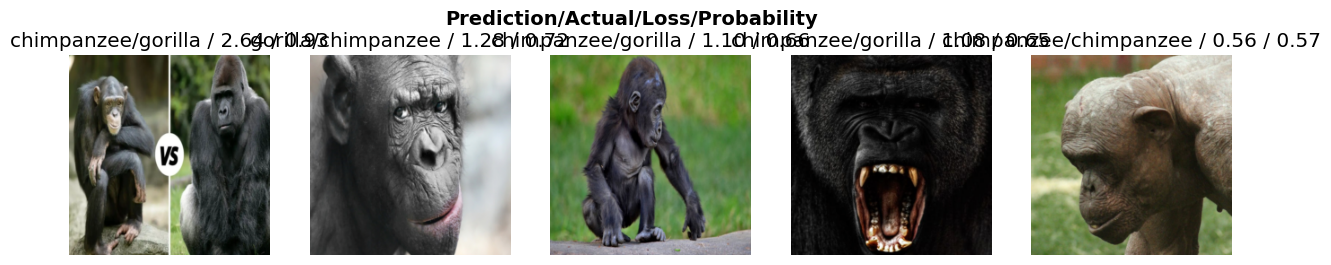

In [124]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/orangutan.jpg')

In [ ]:
learn_inf.dls.vocab

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])
img

In [141]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [142]:
pred,pred_idx,probs = learn_inf.predict(img)

In [143]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: orangutan; Probability: 1.0000')

In [144]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [145]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [146]:
btn_upload = widgets.FileUpload()

In [147]:
VBox([widgets.Label('Select your monkey!'),
      btn_upload, btn_run, out_pl, lbl_pred])